In [11]:
try:
    import ee
    EE_AVAILABLE = True
    try:
        ee.Initialize()
    except:
        pass
except ImportError:
    EE_AVAILABLE = False

import logging
logger = logging.getLogger(__name__)
import math
import numpy as np

In [82]:
def get_surrounding_brandt_tree_cover(lat, lon, distance_deg=0.00006):
    """
    Get the tree cover percentage of the points in the eight cardinal directions around this one.
    
    Args:
        lat (float): Latitude in decimal degrees
        lon (float): Longitude in decimal degrees
        radius_meters (float): Radius in meters for the circular buffer
        
    Returns:
        float: Tree cover percentage (0-100)
    """
    if not EE_AVAILABLE:
        logger.warning("Earth Engine not available. Cannot check Brandt tree cover.")
        return 0.0
    
    def movePoint(lat, lon, bearing, distance):
        dx = distance * math.cos(bearing * math.pi / 180)
        dy = distance * math.sin(bearing * math.pi / 180)

        return lon+dx, lat+dy
        
    try:
        # Create points
        points = []
        for deg in range(0, 360, 45):
            points.append(ee.Geometry.Point(movePoint(lat=lat, lon=lon, bearing=deg, distance=distance_deg)).buffer(1))
        
        # Load the Brandt tree cover dataset (using the merged collection from visualize_tree_cover)
        treeCover = ee.ImageCollection('projects/ee-rscph-5/assets/tree/global') \
            .merge(ee.ImageCollection('projects/ee-rscph-6/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-7/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-8/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-9/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-10/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-11/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-12/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-2/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-3/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-4/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-13/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-14/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-15/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-16/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-17/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-18/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-19/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-20/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-22/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-23/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-24/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-25/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-26/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-27/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-28/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-29/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-30/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-31/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-21/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-47/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-48/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-49/assets/tree/global')) \
            .mosaic()
        
        # Make points ready to calculate stats with
        points = ee.FeatureCollection(points)
        
        # Calculate zonal statistics (mean tree cover within buffer)
        tree_cover_stats = treeCover.reduceRegions(
            reducer=ee.Reducer.mean(),
            collection=points,
            scale=3,  # 3m resolution
        )

        def extractProps(currentFeature, propList):
            propList = ee.List(propList)
            return propList.add(currentFeature.getNumber('mean'))

        first = ee.List([])
        pcts = ee.List(tree_cover_stats.iterate(extractProps, first))
        pcts = pcts.getInfo()

        if pcts is None:
            logger.warning(f"No tree cover data available for {lat}, {lon}")
            return {}

        dirs = ['east', 'northeast', 'north', 'northwest', 'west', 'southwest', 'south', 'southeast']
        return {dirs[i]: pcts[i] for i in range(8)}
        
    except Exception as e:
        logger.error(f"Error checking tree cover: {e}")
        return 0.0

In [83]:
lat, lon = 13.389443, 74.754551
get_surrounding_brandt_tree_cover(lat, lon)

{'east': 6,
 'northeast': 7.193181818181818,
 'north': 23,
 'northwest': 75.39772727272727,
 'west': 80.73333333333333,
 'southwest': 62.141304347826086,
 'south': 20.66292134831461,
 'southeast': 25.40860215053763}

In [85]:
test_data = [(0.2626262626262626, False), (1, False), (3.0103092783505154, False), (4.144329896907217, False), (10.340000000000002, True), (0.1443298969072165, True), (0, False), (0, False), (55, False), (31.393939393939394, False), (5, True), (1, False), (16.92857142857143, True), (56, False), (61, False), (73.85567010309279, False), (0, False), (0, False), (0.4742268041237114, False), (0, False), (0, False), (0, False), (0.5208333333333334, False), (0, False), (0, False), (1, False), (29.323232323232325, True), (4.25, False), (17.577319587628867, False), (15.577319587628867, False), (38.8041237113402, True), (0, False), (6, False), (0, False), (1, False), (18.220000000000002, False), (13, False), (2.2244897959183674, True), (20.20408163265306, False), (56, False), (6.645833333333333, False), (11.717171717171716, False), (22.670103092783506, False), (4.2, False), (1.175257731958763, True), (0, False), (0, False), (0, False), (2, True), (0.24, False), (0.1752577319587629, False), (1, False), (1, False), (1, False), (1, False), (2, False), (0.20618556701030927, False), (5.1020408163265305, False), (30.881188118811878, True), (30.3265306122449, False), (11.53125, False), (2, False), (8.072164948453608, True), (1, False), (14, False), (6, False), (1, False), (0, False), (0, False), (0.9484536082474225, False), (22.367346938775512, False), (44, False), (0, False), (1.0208333333333335, False), (2.21, False), (3.708333333333333, False), (0.21649484536082472, False), (0, False), (0, False), (0, False), (0, False), (0, False), (0.9791666666666667, False), (4.577319587628867, False), (9, True), (6, False), (0.9791666666666667, False), (0, False), (5.329896907216495, False), (12.131313131313131, False), (52.597938144329895, False), (45.44, False), (34.21428571428571, False), (18.19191919191919, False), (12.237113402061855, False), (20.272727272727277, False), (0, False), (0, True), (0, False), (0.3838383838383838, False), (1, True), (0.22916666666666666, False), (0, False), (0, True), (0, False), (0, True), (0, False), (0.56, True), (0, True), (0.08421052631578947, False), (1, False), (0.3263157894736842, False), (4, False), (7.567010309278351, False), (23.071428571428573, True), (22, False), (8.329896907216495, False), (7, False), (5.040404040404041, False), (4.855670103092784, False), (12.252631578947367, False), (6, False), (4.619999999999999, False), (11, False), (29, False), (39.103092783505154, False), (20.346938775510207, False), (23.711340206185568, False), (0.31632653061224486, False), (3.7835051546391756, False), (9, True), (9.052083333333334, False), (4.979591836734694, False), (0, False), (0, False), (0, False), (38.19791666666667, False), (5.744897959183674, False), (3.1428571428571437, False), (2.3402061855670104, False), (1, False), (4.041237113402063, False), (25.15841584158416, False), (45.666666666666664, False), (14.145833333333332, False), (22.29896907216495, False), (11, True), (1.7216494845360826, False), (1, False), (0, False), (0, False), (0.34374999999999994, False), (0, False), (0, False), (0, False), (0, True), (0, False), (0.12371134020618557, False), (2, False), (0.26804123711340205, False), (0, False), (0, True), (0, False), (1, True), (3, False), (4, False), (2, False), (0, False), (0, False), (0, False), (0, False), (0.7659574468085106, False), (4.577319587628866, True), (19.445544554455445, False), (0, False), (0, False), (3, False), (3, False), (2, True), (2, False), (4.690721649484536, True), (2.7399999999999993, False), (2, False), (3.7399999999999998, False), (0, False), (0, False), (0, False), (0, False), (0, False), (0, False), (0, False), (0, False), (0.6288659793814433, False), (0, False), (0, False), (0, False), (0, False), (0, False), (2, False), (2, False), (34.69387755102041, False), (19.95918367346939, False), (16.551020408163268, False), (8, False), (15.387755102040817, False), (27.4020618556701, False), (48, True), (39.72164948453609, False), (0.20618556701030927, False), (5.1020408163265305, False), (30.881188118811878, True), (30.3265306122449, False), (11.53125, False), (2, False), (8.072164948453608, True), (1, False), (9.857142857142858, False), (1.7425742574257423, True), (0.4583333333333333, False), (5.970297029702971, False), (15.175257731958764, False), (5, False), (3.8969072164948457, False), (6, True), (0.29591836734693877, False), (1, False), (0, False), (0, False), (0.5876288659793815, False), (1, True), (0, False), (0, False), (13.474226804123711, False), (11, True), (3.9895833333333335, False), (2.795918367346939, False), (1, False), (1.8854166666666665, False), (2.19, False), (9, False), (0, False), (0, False), (0, False), (0, False), (3.650000000000001, False), (25, False), (29.157894736842106, True), (10.285714285714285, True), (7, False), (29.298969072164947, True), (12, False), (2.6938775510204085, False), (1, False), (1.94, False), (2.7525773195876293, False), (1.24, False)]

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_brandt_tree_masses(data, output_dir, deg):
    # Probability Distribution
    plt.figure(figsize=(10, 6))
    bins = np.linspace(0, 100, 50)

    pos = [x[0] for x in data if x[1]]
    neg = [x[0] for x in data if not x[1]]

    if len(pos) > 0:
        plt.hist(pos, bins=bins, alpha=0.5, 
                label=f'Positive (n={len(pos)})', color='green', density=True)
    if len(neg) > 0:
        plt.hist(neg, bins=bins, alpha=0.5, 
                label=f'Negative (n={len(neg)})', color='red', density=True)

    # plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold={threshold}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'Brandt Tree Count Distributions - {deg} Degrees Delta')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / 'brandt_analysis' / f'{int(deg*100000)}_brandt_tree_counts.png',
                dpi=300, bbox_inches='tight')
    plt.close()

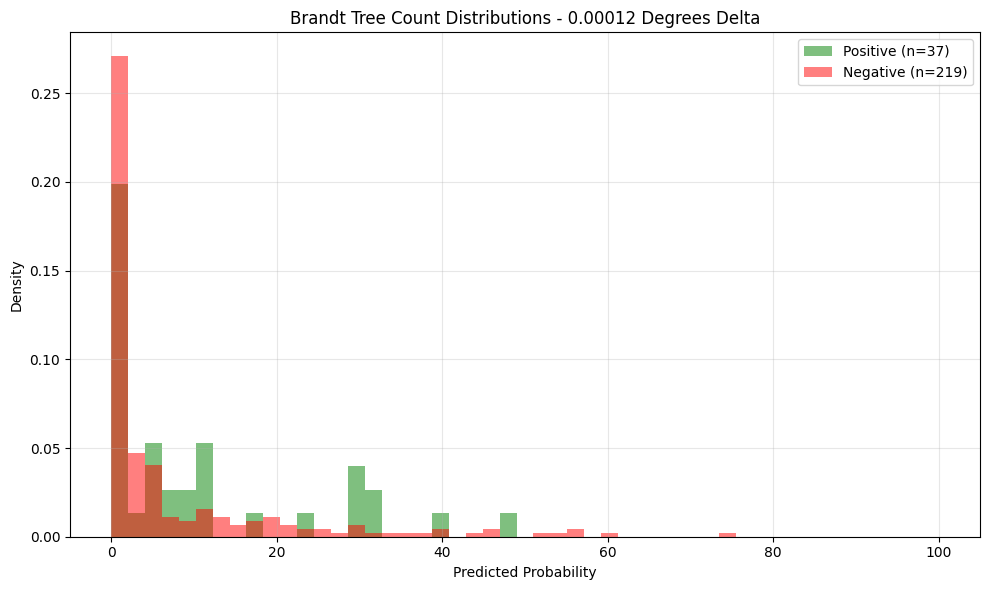

In [100]:
plot_brandt_tree_masses(test_data, Path('tmp'), 0.00012)

In [13]:
def get_brandt_trees_local_max(lat, lon, spacing=1):
    """
    Get the tree cover percentage of the points in the eight cardinal directions around this one.
    
    Args:
        lat (float): Latitude in decimal degrees
        lon (float): Longitude in decimal degrees
        radius_meters (float): Radius in meters for the circular buffer
        
    Returns:
        float: Tree cover percentage (0-100)
    """
    if not EE_AVAILABLE:
        logger.warning("Earth Engine not available. Cannot check Brandt tree cover.")
        return 0.0
    
    def movePoint(lat, lon, bearing, distance):
        dx = distance * math.cos(bearing * math.pi / 180)
        dy = distance * math.sin(bearing * math.pi / 180)

        return lon+dx, lat+dy
        
    try:
        # Create points
        grid_size = 6

        pixel_size_lon = spacing / (111320 * math.cos(math.radians(lat)))
        pixel_size_lat = spacing / 111320

        points = []
        for dx in range(-grid_size, grid_size+1):
            for dy in range(-grid_size, grid_size+1): 
                points.append(ee.Geometry.Point(lon + dx * pixel_size_lon, lat + dy * pixel_size_lat).buffer(spacing / 5))
        
        # Load the Brandt tree cover dataset (using the merged collection from visualize_tree_cover)
        treeCover = ee.ImageCollection('projects/ee-rscph-5/assets/tree/global') \
            .merge(ee.ImageCollection('projects/ee-rscph-6/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-7/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-8/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-9/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-10/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-11/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-12/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-2/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-3/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-4/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-13/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-14/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-15/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-16/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-17/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-18/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-19/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-20/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-22/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-23/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-24/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-25/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-26/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-27/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-28/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-29/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-30/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-31/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-21/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-47/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-48/assets/tree/global')) \
            .merge(ee.ImageCollection('projects/ee-rscph-49/assets/tree/global')) \
            .mosaic()
        
        # Make points ready to calculate stats with
        points = ee.FeatureCollection(points)
        
        # Calculate zonal statistics (mean tree cover within buffer)
        tree_cover_stats = treeCover.reduceRegions(
            reducer=ee.Reducer.mean(),
            collection=points,
            scale=3,  # 3m resolution
        )

        def id(dx, dy):
            return (dx + grid_size) * (2*grid_size+1) + (dy + grid_size)

        def extractProps(currentFeature, propList):
            propList = ee.List(propList)
            return propList.add(currentFeature.getNumber('mean'))

        first = ee.List([])
        pcts = ee.List(tree_cover_stats.iterate(extractProps, first))
        pcts = pcts.getInfo()
        print(pcts)

        if pcts is None:
            logger.warning(f"No tree cover data available for {lat}, {lon}")
            return {}

        ret = []
        for dx in range(-grid_size+1, grid_size):
            for dy in range(-grid_size+1, grid_size): 
                if pcts[id(dx, dy)] >= pcts[id(dx, dy-1)] and pcts[id(dx, dy)] > pcts[id(dx, dy+1)] \
                    and pcts[id(dx, dy)] >= pcts[id(dx-1, dy)] and pcts[id(dx, dy)] > pcts[id(dx+1, dy)]:
                        ret.append((lon + dx * pixel_size_lon, lat + dy * pixel_size_lat, pcts[id(dx, dy)]))

        return ret
        
    except Exception as e:
        logger.error(f"Error checking tree cover: {e}")
        return 0.0
    
def points_to_dirs(points, lat, lon):
    if isinstance(points, list):
        return set([points_to_dirs(x, lat, lon) for x in points])
    
    angle = math.atan2(points[1] - lat, points[0] - lon) * 180 / math.pi
    return angle, points[2]

def min_angle_dif(dir, other_dirs):
    return np.min([(abs(dir[0] - other[0]) + 720) % 360 for other in other_dirs])


In [3]:
lat, lon = 13.390443, 74.751551
pts = get_brandt_trees_local_max(lat, lon, spacing=5)
print(pts)

[0.35555555555555557, 0, 0.6555555555555557, 7.844444444444445, 16.65168539325843, 17.866666666666667, 34.6, 43.9438202247191, 75.43333333333335, 86.73333333333335, 41.10112359550562, 23.211111111111112, 34.866666666666674, 23, 7.337078651685393, 7, 36, 74.6179775280899, 79.5, 124, 131, 101.5, 70, 20.14606741573034, 7, 27, 59, 31.359550561797754, 25, 33, 50.97752808988765, 55.50000000000001, 108, 121, 103, 85, 22.842696629213485, 4, 16, 89.80000000000001, 115.34831460674158, 109.22222222222223, 45.6, 17.97752808988764, 14.611111111111116, 28.6, 32.43820224719101, 49.22222222222222, 56.400000000000006, 37.348314606741575, 37.38888888888889, 43.6, 84, 89.86363636363637, 102, 80, 30.886363636363637, 19.400000000000002, 6, 8, 26.500000000000004, 40, 68.47727272727273, 99, 115, 81, 58, 69, 70, 27.75280898876405, 21.5, 31, 32, 64.10000000000001, 74, 86.9550561797753, 97, 102, 113.91011235955057, 70.95505617977528, 37.466666666666676, 23.89887640449438, 34.348314606741575, 44.15555555555556, 

In [9]:
dirs = list(points_to_dirs(pts, lat, lon))
print(dirs)

[(71.08605861211868, 89.57777777777778), (-121.66492033044744, 115.34831460674158), (168.989919322495, 131), (-30.271626974182084, 95.02222222222223), (32.96514365100756, 88.4)]


In [14]:
min_angle_dif(dirs[0], dirs[1:])

38.12091496111111

In [15]:
items = [f'ee.Geometry.Point({x[0]}, {x[1]})' for x in pts]
print(f'ee.FeatureCollection({items})')

ee.FeatureCollection(['ee.Geometry.Point(74.75132014633878, 13.390487915558749)', 'ee.Geometry.Point(74.75141248780326, 13.390218422206251)', 'ee.Geometry.Point(74.75159717073225, 13.390577746676248)', 'ee.Geometry.Point(74.75168951219675, 13.390532831117499)', 'ee.Geometry.Point(74.75178185366123, 13.39030825332375)'])
